In [9]:
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np
from scipy import signal
from scipy import linalg as la
from scipy import special as ss
from einops import rearrange, repeat, reduce
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# Use 'notebook' instead for interactive plots
%matplotlib inline
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

import seaborn as sns
sns.set(rc={
    "figure.dpi":300,
    'savefig.dpi':300,
    'animation.html':'jshtml',
    'animation.embed_limit':100, # Max animation size in Mb
})
sns.set_context('notebook')
sns.set_style('whitegrid') # or 'ticks'

Load Data

In [17]:
import os 
def read_all_files(directory):
    all_data = {}
    for dirname, _, filenames in os.walk('../data/raw/forex'):
        for i, filename in enumerate(filenames):
            if i <5:
                # print(os.path.join(dirname, filename))
                file_path = os.path.join(dirname, filename)
                if file_path.endswith('.csv'):
                    # print(f"Processing file: {file_path}")
                    parts = filename.split('_')
                    file_current_pair = parts[2]  # Currency pair is at index 2
                    file_year = int(parts[-1].split('.')[0])  # Year is the last element
                    
                    # print(f"Currency pair: {file_current_pair}, Year: {file_year}")
                    data_frame_name = f'{file_current_pair}{file_year}_df'
                    # print(f"DataFrame name: {data_frame_name}")  
                    data = pd.read_csv(file_path, header=None)  # Read without header
                    data.columns = ['date', 'time', 'open', 'high', 'low', 'close', 'amount']
                    data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])
                    # Set 'datetime' column as index
                    data.set_index('datetime', inplace=True)
                    data.drop(['date', 'time'], axis=1, inplace=True)  # Drop 'date' and 'time' columns
          
                    all_data[data_frame_name] = data
                    # print(f"Length of all_data_frames: {len(all_data)}") 
    return all_data
    


In [18]:
directory_path = '../data/raw/forex'
# current_pair = 'GBPAUD'
# year = 2018
all_forex_data = read_all_files(directory_path)

In [19]:
for df_name in all_forex_data:
    print(f"DataFrame Name: {df_name}")

DataFrame Name: GBPAUD2018_df
DataFrame Name: GBPAUD2019_df
DataFrame Name: GBPAUD2020_df
DataFrame Name: GBPAUD2021_df
DataFrame Name: GBPAUD2022_df


In [20]:
df = all_forex_data['GBPAUD2018_df']
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 371504 entries, 2018-01-01 17:02:00 to 2018-12-31 16:58:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    371504 non-null  float64
 1   high    371504 non-null  float64
 2   low     371504 non-null  float64
 3   close   371504 non-null  float64
 4   amount  371504 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 17.0 MB


Extract one day data for trial run

In [21]:
mini = df.loc['2018-01','open']
forex_df = pd.DataFrame({'open': mini})
forex_df.index = pd.to_datetime(forex_df.index)
forex_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32049 entries, 2018-01-01 17:02:00 to 2018-01-31 23:59:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    32049 non-null  float64
dtypes: float64(1)
memory usage: 500.8 KB


In [10]:
# test_data = df.loc['2018-02-01', 'open']
# test_df = pd.DataFrame({'open': test_data})
# test_df.index = pd.to_datetime(test_df.index)
# test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1438 entries, 2018-02-01 00:00:00 to 2018-02-01 23:59:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1438 non-null   float64
dtypes: float64(1)
memory usage: 22.5 KB


Split data set into train and test

In [10]:
train_df_len = math.ceil(len(forex_df)*0.9)
train_df_len

28845

In [22]:
train_data = forex_df[:train_df_len].iloc[:,0]
test_data = forex_df[train_df_len:].iloc[:,0]
print(train_data.shape, test_data.shape)
                                        

(28845,) (3204,)


In [25]:
dataset_train = np.reshape(train_data.values, (-1,1))
dataset_train.shape

(28845, 1)

In [26]:
dataset_test = np.reshape(test_data.values, (-1,1))
dataset_test.shape

(3204, 1)

transform data into sequence

In [9]:
### feature engineering: date feature: date, year, week, month, lag feature, rolling feature

In [56]:
sequence_length = 60 # number of time steps to look back
X_train, y_train = [],[]
for i in range(len(dataset_train)-sequence_length):
    X_train.append(dataset_train[i:(i+sequence_length),0])
    y_train.append(dataset_train[(i+1):(i+sequence_length),0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [57]:
X_train = torch.tensor(X_train, dtype =torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
X_train.shape, y_train.shape

(torch.Size([28785, 60]), torch.Size([28785, 59]))

In [32]:
sequence_length = 60 # number of time steps to look back
X_test, y_test = [],[]
for i in range(len(dataset_test)-sequence_length):
    X_test.append(dataset_test[i:(i+sequence_length)])
    y_test.append(dataset_train[(i+1):(i+sequence_length)])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = torch.tensor(X_test, dtype =torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)
X_test.shape, y_test.shape

(torch.Size([3144, 60, 1]), torch.Size([3144, 59, 1]))

In [11]:
from torch.utils.data import DataLoader,Dataset

In [11]:
# # Create TensorDataset
# dataset_train = TensorDataset(torch.from_numpy(X_train).float(),torch.from_numpy(y_train).float())
# print(len(dataset_train))

In [12]:
# batch_size = 50

# # Create data loaders.
# train_dataloader = DataLoader(train_df, batch_size=batch_size)
# test_dataloader = DataLoader(test_df, batch_size=batch_size)


In [13]:
# train_df = train_df.reset_index()
# display(train_df.head())
# test_df = test_df.reset_index()
# display(test_df.head())

In [33]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


In [41]:
# Utility functions for performing matrix scans faster
# The HiPPO functions also have pedagogical sequential versions, so this cell is not required

def shift_up(a, s=None, drop=True, dim=0):
    assert dim == 0
    if s is None:
        s = torch.zeros_like(a[0, ...])
    s = s.unsqueeze(dim)
    if drop:
        a = a[:-1, ...]
    return torch.cat((s, a), dim=dim)

def batch_mult(A, u, has_batch=None):
    """ Matrix mult A @ u with special case to save memory if u has additional batch dim

    The batch dimension is assumed to be the second dimension
    A : (L, ..., N, N)
    u : (L, [B], ..., N)
    has_batch: True, False, or None. If None, determined automatically

    Output:
    x : (L, [B], ..., N)
      A @ u broadcasted appropriately
    """

    if has_batch is None:
        has_batch = len(u.shape) >= len(A.shape)

    if has_batch:
        u = u.permute([0] + list(range(2, len(u.shape))) + [1])
    else:
        u = u.unsqueeze(-1)
    v = (A @ u)
    if has_batch:
        v = v.permute([0] + [len(u.shape)-1] + list(range(1, len(u.shape)-1)))
    else:
        v = v[..., 0]
    return v

def interleave(a, b, uneven=False, dim=0):
    """ Interleave two tensors of same shape """
    # assert(a.shape == b.shape)
    assert dim == 0 # TODO temporary to make handling uneven case easier
    if dim < 0:
        dim = N + dim
    if uneven:
        a_ = a[-1:, ...]
        a = a[:-1, ...]
    c = torch.stack((a, b), dim+1)
    out_shape = list(a.shape)
    out_shape[dim] *= 2
    c = c.view(out_shape)
    if uneven:
        c = torch.cat((c, a_), dim=dim)
    return c


def variable_unroll_general_sequential(A, u, s, op, variable=True):
    """ Unroll with variable (in time/length) transitions A with general associative operation

    A : ([L], ..., N, N) dimension L should exist iff variable is True
    u : (L, [B], ..., N) updates
    s : ([B], ..., N) start state
    output : x (..., N)
    x[i, ...] = A[i]..A[0] s + A[i..1] u[0] + ... + A[i] u[i-1] + u[i]
    """

    if not variable:
        A = A.expand((u.shape[0],) + A.shape)

    outputs = []
    for (A_, u_) in zip(torch.unbind(A, dim=0), torch.unbind(u, dim=0)):
        s = op(A_, s)
        s = s + u_
        outputs.append(s)

    output = torch.stack(outputs, dim=0)
    return output

def variable_unroll_general(A, u, s, op, compose_op=None, sequential_op=None, variable=True, recurse_limit=16):
    """ Bottom-up divide-and-conquer version of variable_unroll.

    compose is an optional function that defines how to compose A without multiplying by a leaf u
    """

    if u.shape[0] <= recurse_limit:
        if sequential_op is None:
            sequential_op = op
        return variable_unroll_general_sequential(A, u, s, sequential_op, variable)

    if compose_op is None:
        compose_op = op

    uneven = u.shape[0] % 2 == 1
    has_batch = len(u.shape) >= len(A.shape)

    u_0 = u[0::2, ...]
    u_1 = u[1::2, ...]

    if variable:
        A_0 = A[0::2, ...]
        A_1 = A[1::2, ...]
    else:
        A_0 = A
        A_1 = A

    u_0_ = u_0
    A_0_ = A_0
    if uneven:
        u_0_ = u_0[:-1, ...]
        if variable:
            A_0_ = A_0[:-1, ...]

    u_10 = op(A_1, u_0_) # batch_mult(A_1, u_0_, has_batch)
    u_10 = u_10 + u_1
    A_10 = compose_op(A_1, A_0_)

    # Recursive call
    x_1 = variable_unroll_general(A_10, u_10, s, op, compose_op, sequential_op, variable=variable, recurse_limit=recurse_limit)

    x_0 = shift_up(x_1, s, drop=not uneven)
    x_0 = op(A_0, x_0) # batch_mult(A_0, x_0, has_batch)
    x_0 = x_0 + u_0


    x = interleave(x_0, x_1, uneven, dim=0) # For some reason this interleave is slower than in the (non-variable) unroll_recursive
    return x

def variable_unroll_matrix(A, u, s=None, variable=True, recurse_limit=16):
    if s is None:
        s = torch.zeros_like(u[0])
    has_batch = len(u.shape) >= len(A.shape)
    op = lambda x, y: batch_mult(x, y, has_batch)
    sequential_op = lambda x, y: batch_mult(x.unsqueeze(0), y.unsqueeze(0), has_batch)[0]
    matmul = lambda x, y: x @ y
    return variable_unroll_general(A, u, s, op, compose_op=matmul, sequential_op=sequential_op, variable=variable, recurse_limit=recurse_limit)


In [42]:
def transition(measure, N, **measure_args):
    # Laguerre (translated)
    if measure == 'lagt':
        b = measure_args.get('beta', 1.0)
        A = np.eye(N) / 2 - np.tril(np.ones((N, N)))
        B = b * np.ones((N, 1))
    # Legendre (translated)
    elif measure == 'legt':
        Q = np.arange(N, dtype=np.float64)
        R = (2*Q + 1) ** .5
        j, i = np.meshgrid(Q, Q)
        A = R[:, None] * np.where(i < j, (-1.)**(i-j), 1) * R[None, :]
        B = R[:, None]
        A = -A
    # Legendre (scaled)
    elif measure == 'legs':
        q = np.arange(N, dtype=np.float64)
        col, row = np.meshgrid(q, q)
        r = 2 * q + 1
        M = -(np.where(row >= col, r, 0) - np.diag(q))
        T = np.sqrt(np.diag(2 * q + 1))
        A = T @ M @ np.linalg.inv(T)
        B = np.diag(T)[:, None]
        B = B.copy() # Otherwise "UserWarning: given NumPY array is not writeable..." after torch.as_tensor(B)
    elif measure == 'fourier':
        freqs = np.arange(N//2)
        d = np.stack([np.zeros(N//2), freqs], axis=-1).reshape(-1)[1:]
        A = 2*np.pi*(-np.diag(d, 1) + np.diag(d, -1))
        B = np.zeros(N)
        B[0::2] = 2
        B[0] = 2**.5
        A = A - B[:, None] * B[None, :]
        # A = A - np.eye(N)
        B *= 2**.5
        B = B[:, None]

    return A, B

def measure(method, c=0.0):
    if method == 'legt':
        fn = lambda x: np.heaviside(x, 0.0) * np.heaviside(1.0-x, 0.0)
    elif method == 'legs':
        fn = lambda x: np.heaviside(x, 1.0) * np.exp(-x)
    elif method == 'lagt':
        fn = lambda x: np.heaviside(x, 1.0) * np.exp(-x)
    elif method in ['fourier']:
        fn = lambda x: np.heaviside(x, 1.0) * np.heaviside(1.0-x, 1.0)
    else: raise NotImplementedError
    fn_tilted = lambda x: np.exp(c*x) * fn(x)
    return fn_tilted



In [43]:
def basis(method, N, vals, c=0.0, truncate_measure=True):
    """
    vals: list of times (forward in time)
    returns: shape (T, N) where T is length of vals
    """
    if method == 'legt':
        eval_matrix = ss.eval_legendre(np.arange(N)[:, None], 2*vals-1).T
        eval_matrix *= (2*np.arange(N)+1)**.5 * (-1)**np.arange(N)
    elif method == 'legs':
        _vals = np.exp(-vals)
        eval_matrix = ss.eval_legendre(np.arange(N)[:, None], 1-2*_vals).T # (L, N)
        eval_matrix *= (2*np.arange(N)+1)**.5 * (-1)**np.arange(N)
    elif method == 'lagt':
        vals = vals[::-1]
        eval_matrix = ss.eval_genlaguerre(np.arange(N)[:, None], 0, vals)
        eval_matrix = eval_matrix * np.exp(-vals / 2)
        eval_matrix = eval_matrix.T
    elif method == 'fourier':
        cos = 2**.5 * np.cos(2*np.pi*np.arange(N//2)[:, None]*(vals)) # (N/2, T/dt)
        sin = 2**.5 * np.sin(2*np.pi*np.arange(N//2)[:, None]*(vals)) # (N/2, T/dt)
        cos[0] /= 2**.5
        eval_matrix = np.stack([cos.T, sin.T], axis=-1).reshape(-1, N) # (T/dt, N)
#     print("eval_matrix shape", eval_matrix.shape)
    
    if truncate_measure:
        eval_matrix[measure(method)(vals) == 0.0] = 0.0
    
    p = torch.tensor(eval_matrix)
    p *= np.exp(-c*vals)[:, None] # [::-1, None]
    return p


In [44]:
class HiPPOScale(nn.Module):
    """ Vanilla HiPPO-LegS model (scale invariant instead of time invariant) """
    def __init__(self, N, method='legs', max_length=1024, discretization='bilinear'):
        """
        max_length: maximum sequence length
        """
        super().__init__()
        self.N = N
        A, B = transition(method, N)
        B = B.squeeze(-1)
        A_stacked = np.empty((max_length, N, N), dtype=A.dtype)
        B_stacked = np.empty((max_length, N), dtype=B.dtype)
        for t in range(1, max_length + 1):
            At = A / t
            Bt = B / t
            if discretization == 'forward':
                A_stacked[t - 1] = np.eye(N) + At
                B_stacked[t - 1] = Bt
            elif discretization == 'backward':
                A_stacked[t - 1] = la.solve_triangular(np.eye(N) - At, np.eye(N), lower=True)
                B_stacked[t - 1] = la.solve_triangular(np.eye(N) - At, Bt, lower=True)
            elif discretization == 'bilinear':
                A_stacked[t - 1] = la.solve_triangular(np.eye(N) - At / 2, np.eye(N) + At / 2, lower=True)
                B_stacked[t - 1] = la.solve_triangular(np.eye(N) - At / 2, Bt, lower=True)
            else: # ZOH
                A_stacked[t - 1] = la.expm(A * (math.log(t + 1) - math.log(t)))
                B_stacked[t - 1] = la.solve_triangular(A, A_stacked[t - 1] @ B - B, lower=True)
        self.register_buffer('A_stacked', torch.Tensor(A_stacked)) # (max_length, N, N)
        self.register_buffer('B_stacked', torch.Tensor(B_stacked)) # (max_length, N)

        vals = np.linspace(0.0, 1.0, max_length)
        self.eval_matrix = torch.Tensor((B[:, None] * ss.eval_legendre(np.arange(N)[:, None], 2 * vals - 1)).T  )

    def forward(self, inputs, fast=True):
        """
        inputs : (length, ...)
        output : (length, ..., N) where N is the order of the HiPPO projection
        """

        L = inputs.shape[0]

        inputs = inputs.unsqueeze(-1)
        u = torch.transpose(inputs, 0, -2)
        u = u * self.B_stacked[:L]
        u = torch.transpose(u, 0, -2) # (length, ..., N)

        if fast:
            result = variable_unroll_matrix(self.A_stacked[:L], u)
            return result
        
        c = torch.zeros(u.shape[1:]).to(inputs)
        cs = []
        for t, f in enumerate(inputs):
            c = F.linear(c, self.A_stacked[t]) + self.B_stacked[t] * f
            cs.append(c)
        return torch.stack(cs, dim=0)

    def reconstruct(self, c):
        a = self.eval_matrix.to(c) @ c.unsqueeze(-1)
        return a



In [51]:
class HiPPO(nn.Module):
    """ Linear time invariant x' = Ax + Bu """
    def __init__(self, N, method='legt', dt=1.0, T=1.0, discretization='bilinear', scale=False, c=0.0):
        """
        N: the order of the HiPPO projection
        dt: discretization step size - should be roughly inverse to the length of the sequence
        """
        super().__init__()
        self.method = method
        self.N = N
        self.dt = dt
        self.T = T
        self.c = c
        
        A, B = transition(method, N)
        A = A + np.eye(N)*c
        self.A = A
        self.B = B.squeeze(-1)
        self.measure_fn = measure(method)
        
        C = np.ones((1, N))
        D = np.zeros((1,))
        dA, dB, _, _, _ = signal.cont2discrete((A, B, C, D), dt=dt, method=discretization)

        dB = dB.squeeze(-1)

        self.register_buffer('dA', torch.Tensor(dA)) # (N, N)
        self.register_buffer('dB', torch.Tensor(dB)) # (N,)

        self.vals = np.arange(0.0, T, dt)
        self.eval_matrix = basis(self.method, self.N, self.vals, c=self.c) # (T/dt, N)
        self.measure = measure(self.method)(self.vals)


    def forward(self, inputs, fast=True):
        """
        inputs : (length, ...)
        output : (length, ..., N) where N is the order of the HiPPO projection
        """

        inputs = inputs.unsqueeze(-1)
        u = inputs * self.dB # (length, ..., N)

        if fast:
            dA = repeat(self.dA, 'm n -> l m n', l=u.size(0))
            return variable_unroll_matrix(dA, u)
        
        c = torch.zeros(u.shape[1:]).to(inputs)
        cs = []
        for f in inputs:
            c = F.linear(c, self.dA) + self.dB * f
            cs.append(c)
        return torch.stack(cs, dim=0)
    


    def reconstruct(self, c, evals=None): # TODO take in a times array for reconstruction
        """
        c: (..., N,) HiPPO coefficients (same as x(t) in S4 notation)
        output: (..., L,)
        """
        if evals is not None:
            eval_matrix = basis(self.method, self.N, evals)
        else:
            eval_matrix = self.eval_matrix

        m = self.measure[self.measure != 0.0]

        c = c.unsqueeze(-1)
        y = eval_matrix.to(c) @ c
        return y.squeeze(-1).flip(-1)


In [50]:
"""N is vector, size of recurrent A matrix, know as 'd-state'"""

# model = HiPPO(method=method, N=64, dt=1).to(device)
 
# loss_fn =nn.MSELoss(reduction='mean')
 
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, monmentum = 0.9)
# print(model)

"N is vector, size of recurrent A matrix, know as 'd-state'"

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Visualize the HiPPO function reconstruction theory in the spirit of the original paper. A random function $u(t)$ (black) is generated and processed sequentially by a HiPPO operator $x'(t) = A(t) x(t) + B(t) u(t)$. At the end of the sequence, the final state $x(t)$, which has dimension much smaller than the length of the sequence, can be used (via a linear projection) to approximately reconstruct the entire input.

In [ ]:
### Synthetic data generation

def whitesignal(period, dt, freq, rms=0.5, batch_shape=()):
    """
    Produces output signal of length period / dt, band-limited to frequency freq
    Output shape (*batch_shape, period/dt)
    Adapted from the nengo library
    """

    if freq is not None and freq < 1. / period:
        raise ValueError(f"Make ``{freq=} >= 1. / {period=}`` to produce a non-zero signal",)

    nyquist_cutoff = 0.5 / dt
    if freq > nyquist_cutoff:
        raise ValueError(f"{freq} must not exceed the Nyquist frequency for the given dt ({nyquist_cutoff:0.3f})")

    n_coefficients = int(np.ceil(period / dt / 2.))
    shape = batch_shape + (n_coefficients + 1,)
    sigma = rms * np.sqrt(0.5)
    coefficients = 1j * np.random.normal(0., sigma, size=shape)
    coefficients[..., -1] = 0.
    coefficients += np.random.normal(0., sigma, size=shape)
    coefficients[..., 0] = 0.

    set_to_zero = np.fft.rfftfreq(2 * n_coefficients, d=dt) > freq
    coefficients *= (1-set_to_zero)
    power_correction = np.sqrt(1. - np.sum(set_to_zero, dtype=float) / n_coefficients)
    if power_correction > 0.: coefficients /= power_correction
    coefficients *= np.sqrt(2 * n_coefficients)
    signal = np.fft.irfft(coefficients, axis=-1)
    signal = signal - signal[..., :1]  # Start from 0
    return signal


visualize = False
if visualize:
    x = whitesignal(1., high=3.0, dt=0.01, batch_shape=(2,))
    print(x.shape)
    plt.plot(np.arange(x.shape[-1]), x[0])
    plt.plot(np.arange(x.shape[-1]), x[1])
    plt.show()



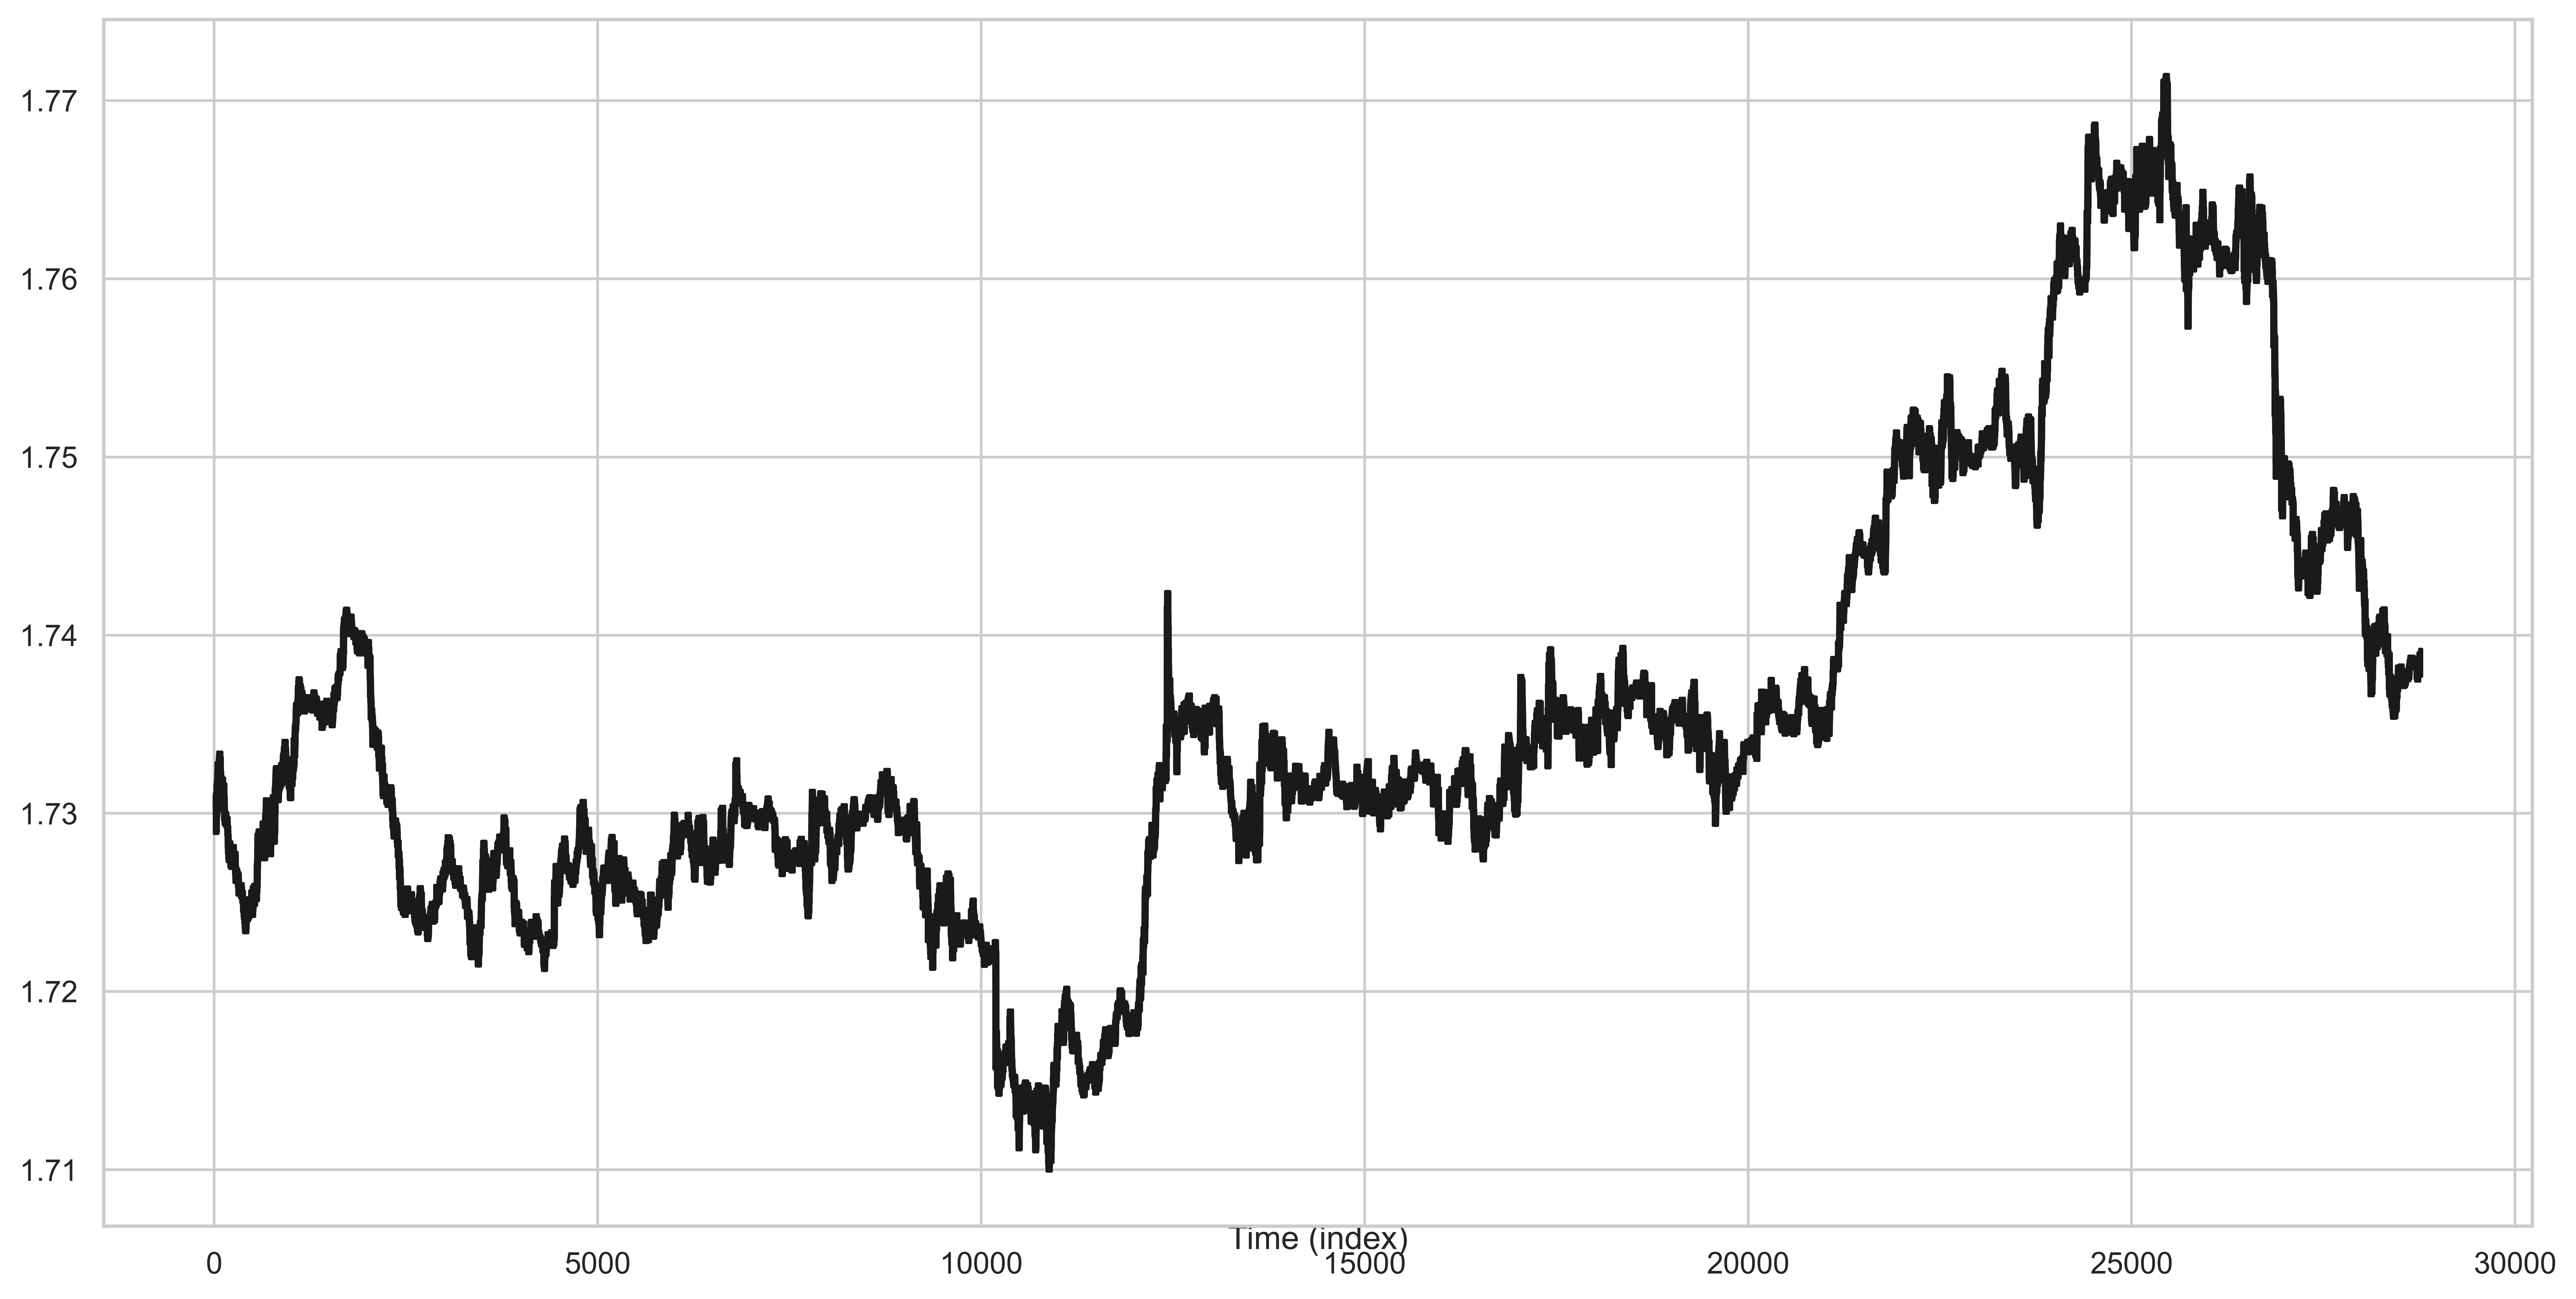

In [62]:
# def forex_signal(forex_df):
#     u = torch.tensor(forex_df, dtype=torch.float)
#     return u

# Plotting function
def plot_forex_data(forex_df):
    u = forex_df

    plt.figure(figsize=(16, 8))
    plt.plot(np.arange(len(u)), u, 'k', linewidth=1.0, label='Forex Data')

    # Additional plotting customization or analysis can be added here

    plt.xlabel('Time (index)', labelpad=-20)
    plt.show()

plot_forex_data(X_train)


In [33]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
np.random.seed(0)
def plot(T, dt, N, freq):
    vals = np.arange(0.0, T, dt)
    
    u = forex_signal(T, dt)
    u = torch.tensor(u, dtype=torch.float)
    u = u.to(device)

    plt.figure(figsize=(16, 8))
    offset = 0.0
    plt.plot(vals, u.cpu()+offset, 'k', linewidth=1.0, label='Input u(t)')

    # Linear Time Invariant (LTI) methods x' = Ax + Bu
    lti_methods = [
        'legs',
        'legt',
        'fourier',
    ]
    
    for method in lti_methods:
        hippo = HiPPO(method=method, N=N, dt=dt, T=T).to(device)
        u_hippo = hippo.reconstruct(hippo(u))[-1].cpu()
        plt.plot(vals[-len(u_hippo):], u_hippo, label=method)
        
    # Original HiPPO-LegS, which uses time-varying SSM x' = 1/t [ Ax + Bu]
    # we call this "linear scale invariant"
    lsi_methods = ['legs']
    for method in lsi_methods:
        hippo = HiPPOScale(N=N, method=method, max_length=int(T/dt)).to(device)
        u_hippo = hippo.reconstruct(hippo(u))[-1].cpu()
        plt.plot(vals[-len(u_hippo):], u_hippo, label=method+' (scaled)')


    # plt.xlabel('Time (normalized)', labelpad=-10)
    # plt.savefig(f'function_approximation.pdf', bbox_inches='tight')
    plt.legend()
    plt.show()
    plt.close()


plot(T=train_df, dt=1, N=64, freq=3.0)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# Animation code from "How to Train Your HiPPO"

sns.set_style('ticks')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def plt_lines(x, y, color, size, label=None):
    return plt.plot(x, y, color, linewidth=size, label=label)[0]

def update_lines(ln, x, y):
    ln.set_data(x, y)

def animate_hippo(
    method, 
    T=5, dt=5e-4, N=64, freq=20.0,
    interval=100,
    plot_hippo=False, hippo_offset=0.0, label_hippo=False,
    plot_measure=False, measure_offset=-3.0, label_measure=False,
    plot_coeff=None, coeff_offset=3.0,
    plot_s4=False, s4_offset=6.0,
    plot_hippo_type='line', plot_measure_type='line', plot_coeff_type='line',
    size=1.0,
    plot_legend=True, plot_xticks=True, plot_box=True,
    plot_vline=False,
    animate_u=False,
    seed=2,
):
    np.random.seed(seed)

    vals = np.arange(0, int(T/dt)+1)
    L = int(T/dt)+1

    u = torch.FloatTensor(whitesignal(T, dt, freq=freq))
    u = F.pad(u, (1, 0))
    u = u + torch.FloatTensor(np.sin(1.5*np.pi/T*np.arange(0, T+dt, dt))) # add 3/4 of a sin cycle
    u = u.to(device)

    hippo = HiPPO(method=method, N=N, dt=dt, T=T).to(device)
    coef_hippo = hippo(u).cpu().numpy()
    h_hippo = hippo.reconstruct(hippo(u)).cpu().numpy()
    u = u.cpu().numpy()

    fig, ax = plt.subplots(figsize=(12, 4))
    
    if animate_u:
        ln_u = plt_lines([], [], 'k', size, label='Input $u(t)$')
    else:
        plt_lines(vals, u, 'k', size, label='Input $u(t)$')
    
    if plot_hippo:
        label_args = {'label': 'HiPPO reconstruction'} if label_hippo else {}
        ln = plt_lines([], [], size=size, color='red', **label_args)

    if plot_measure:
        label_args = {'label': 'HiPPO Measure'} if label_measure else {}
        ln_measure = plt_lines(vals, np.zeros(len(vals))+measure_offset, size=size, color='green', **label_args)

    if plot_coeff is None: plot_coeff = []
    if isinstance(plot_coeff, int): plot_coeff = [plot_coeff]
    if len(plot_coeff) > 0:
        ln_coeffs = [
            plt_lines([], [], size=size, color='blue')
            for _ in plot_coeff
        ]
        plt_lines([], [], size=size, color='blue', label='State $x(t)$') # For the legend
        
    
    ### Y AXIS LIMITS
    if plot_measure:
        min_y = measure_offset
    else:
        min_y = np.min(u)
        
    if len(plot_coeff) > 0:
        max_u = np.max(u) + coeff_offset
    else:
        max_u = np.max(u)


    C = np.random.random(N)
    s4 = np.sum(coef_hippo * C, axis=-1)
    max_s4 = 0.0
    if plot_s4:
        ln_s4 = plt_lines([], [], size=size, color='red', label='Output $y(t)$')
        max_s4 = np.max(s4)+s4_offset
    
    if plot_vline:
        ln_vline = ax.axvline(0, ls='-', color='k', lw=1)

    if plot_legend:
        plt.legend(loc='upper left', fontsize='x-small')


    def init():
        left_endpoint = vals[0]
        ax.set_xlim(left_endpoint, vals[-1]+1)
        ax.set_ylim(min_y, max(max_u, max_s4))
        ax.set_yticks([])
        if not plot_xticks: ax.set_xticks([])
        if not plot_box: plt.box(False)
        return [] # ln,

    def update(frame):
        if animate_u:
            xdata = np.arange(frame)
            ydata = u[:frame]
            update_lines(ln_u, xdata, ydata)

        m = np.zeros(len(vals))
        m[:frame] = hippo.measure_fn(np.arange(frame)*dt)[::-1]
        xdata = vals
        if plot_measure:
            update_lines(ln_measure, xdata, m+measure_offset)
        
        if plot_hippo:   
            ydata = h_hippo[frame] + hippo_offset
            m2 = hippo.measure_fn(np.arange(len(ydata))*dt)[::-1]
            # Remove reconstruction where measure is 0
            ydata[m2 == 0.0] = np.nan
            xdata = np.arange(frame-len(ydata), frame)
            update_lines(ln, xdata, ydata)

        if len(plot_coeff) > 0:
            for coeff, ln_coeff in zip(plot_coeff, ln_coeffs):
                update_lines(ln_coeff, np.arange(frame), coef_hippo[:frame, coeff] + coeff_offset)
        if plot_s4: # Only scale case; scale case should copy plot_hippo logic
            update_lines(ln_s4, np.arange(0, frame), s4[:frame] + s4_offset)
            
        if plot_vline:
            ln_vline.set_xdata([frame, frame])

        return []

    ani = FuncAnimation(fig, update,
                        frames=np.arange(0, int(T*1000/interval)+1)*int(interval/1000/dt),
                        interval=interval,
                        init_func=init, blit=True)

    return ani

Here, an input signal $u(t)$ (Black) is processed by the HiPPO operator $x'(t) = \boldsymbol{A}x(t) + \boldsymbol{B}u(t)$
 for 10000 steps, maintaining a state $x(t) \in \mathbb{R}^{64}$. At all times, the current state represents a compression of the history of $u(t)$ and can be linearly projected to approximately reconstruct it (Red). This approximation is optimal with respect to an exponentially-decaying measure (Green).

In [ ]:
# Visualize HiPPO online reconstruction

ani = animate_hippo(
    'legs', # Try 'legt' or 'fourier'
    T=5, dt=5e-4, N=64, interval=100,
#     T=1, dt=1e-3, N=64, interval=200, # Faster rendering for testing
    size=1.0,

    animate_u=True,
    plot_hippo=True, hippo_offset=0.0, label_hippo=True,
    plot_s4=False, s4_offset=6.0,
    plot_measure=True, measure_offset=-3.0, label_measure=True,
    plot_coeff=[], coeff_offset=3.0,
    plot_legend=True, plot_xticks=True, plot_box=True,
    plot_vline=True,
)
ani

In [ ]:
# Visualize S4

ani = animate_hippo(
    'legs', # Try 'legt' or 'fourier'
    T=5, dt=5e-4, N=64, interval=100,
    size=1.0,

    animate_u=True,
    plot_hippo=False, hippo_offset=0.0, label_hippo=True,
    plot_s4=True, s4_offset=6.0,
    plot_measure=False, measure_offset=-3.0, label_measure=True,
    plot_coeff=[0,1,2,3], coeff_offset=3.0,
    plot_legend=True, plot_xticks=True, plot_box=True,
    plot_vline=True,
)
ani

In [ ]:
ani.save(
    's4_operator_legs.gif',
    savefig_kwargs={
        # 'transparent': True,
        # 'bbox_inches': 'tight',
        'pad_inches': 0,
    }
)

In [ ]:
from torch.utils import TensorDataset
dataset_train = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())